In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import fast_simulation_with_arb as sim
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [2]:
# Market Parameters

T = 1 # Time horizon
N = 1440 # Number of periods
dt = T/N # Time increment
buy = 2500.*dt # Constant trade size for systematic buyers
sell = -2500.*dt # Constant trade size for systematic sellers
eta0 = 0.005 # CEX proportional cost
eta1 = 0.0045 # CPMM proportional cost
etaA = 0.00 # Arbitrageur cost
X = 30000000 # Initial CPMM Dollar Reserves
Y = 10000 # Initial CPMM Asset Reserves
S = X/Y # Initial CEX Price
sigma = 0.05 # Standard deviation of CEX price shock
mu = 0  # Mean of CEX price shock
M = 1 # Total number of sims
time = np.array([i * dt for i in range(N+1)]) # Time grid

In [3]:
# Run Simulation

S0 = sim.CEX_Price(S, mu, sigma, dt, N, M) # Generate price series

filtr_bfs , filtr_sfs =  sim.generate_trade_filters(N, M) # Generate buyer-first/seller-first trade filter

X_reserves, Y_reserves, ref_price, amm_price, buy_rev, sell_rev, arb_rev, hedge_val, buy_vol, sell_vol, arb_vol = \
                        sim.fast_simulation(M, N, T, dt, buy, sell, eta0, eta1, etaA, S0, X, Y, filtr_bfs, filtr_sfs) # Market simulation

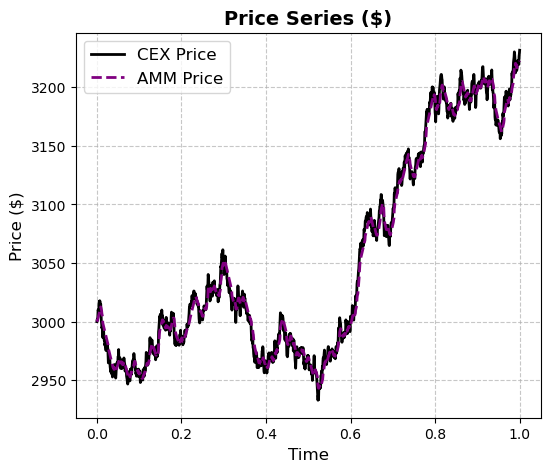

In [4]:
# Plot CEX price and AMM price
plt.figure(figsize=(6, 5)) # Set figure size
plt.plot(time, ref_price, color="black", linestyle="-", linewidth=2, label="CEX Price") 
plt.plot(time, amm_price, color="purple", linestyle="--", linewidth=2, label="AMM Price") 

# Title and labels
plt.title("Price Series ($)", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)

# Legend
plt.legend(loc="best", fontsize=12)

# Grid
plt.grid(True, linestyle="--", alpha=0.7)

plt.savefig('sample_price_series.pdf',bbox_inches='tight')

# Show plot
plt.show()


In [11]:
# Market Parameters (common)
T      = 1           # Time horizon
N      = 1440        # Number of periods
dt     = T / N       # Time increment
buy    = 2500. * dt  # Systematic buy size
sell   = -2500. * dt # Systematic sell size
eta0   = 0.005       # CEX proportional cost
etaA   = 0.000       # Arbitrageur cost
X      = 30_000_000  # CPMM dollar reserves
Y      = 10_000      # CPMM asset reserves
S      = X / Y       # Initial CEX price
sigma  = 0.05        # Volatility of CEX price
mu     = 0           # Drift of CEX price
M      = 20_000     # Monte Carlo paths
time   = np.linspace(0, T, N+1)

# η₁ values to sweep over
eta1_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Storage for results
results = {}

for eta1 in eta1_values:
    # 1) generate CEX price paths
    S0 = sim.CEX_Price(S, mu, sigma, dt, N, M)
    
    # 2) filters for buyer-first / seller-first
    filtr_bfs, filtr_sfs = sim.generate_trade_filters(N, M)
    
    # 3) fast simulation
    X_reserves, Y_reserves, ref_price, amm_price, buy_rev, sell_rev, arb_rev, hedge_val, buy_vol, sell_vol, arb_vol = \
        sim.fast_simulation(M, N, T, dt, buy, sell, eta0, eta1, etaA, S0, X, Y, filtr_bfs, filtr_sfs)
    
    # 4) compute diagnostics
    ratio       = amm_price[:-1] / ref_price[1:, ] # amm_price / ref_price
    pool_value  = X_reserves + Y_reserves * ref_price
    hedge_err   = hedge_val - pool_value
    pnl_hedged  = np.cumsum(buy_rev + sell_rev + arb_rev, axis=0) - hedge_err
    fee_revenue = np.cumsum(buy_rev + sell_rev + arb_rev, axis=0)
    amm_vol = np.cumsum(buy_vol + np.abs(sell_vol) + np.abs(arb_vol), axis=0)
    
    # 5) store
    results[eta1] = {
        'ratio':      ratio,
        'pool_value': pool_value,
        'hedge_err':  hedge_err,
        'pnl_hedged': pnl_hedged,
        'fee_revenue': fee_revenue,
        'AMM_vol': amm_vol
    }

# Example: inspect the PnL for η₁ = 0.005
print("PnL shape for η₁=0.005:", results[0.005]['pnl_hedged'].shape)


PnL shape for η₁=0.005: (1441, 20000)


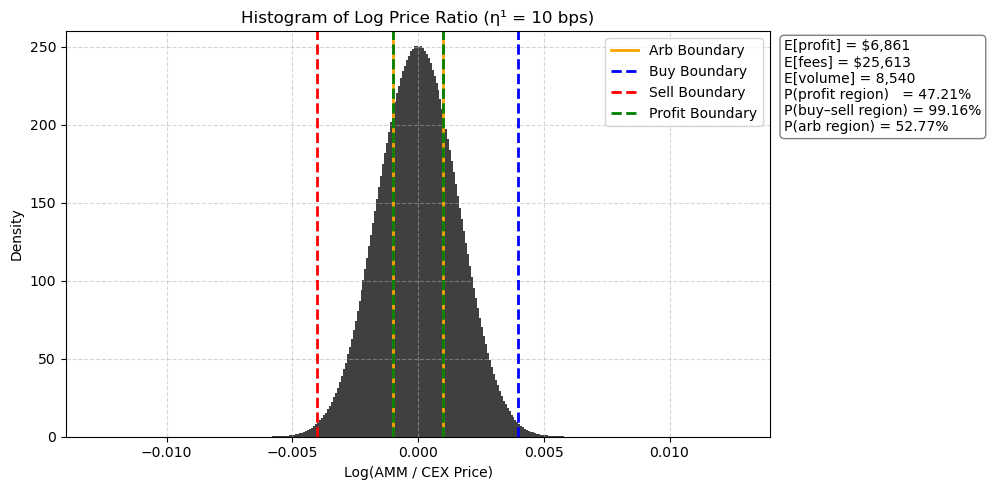

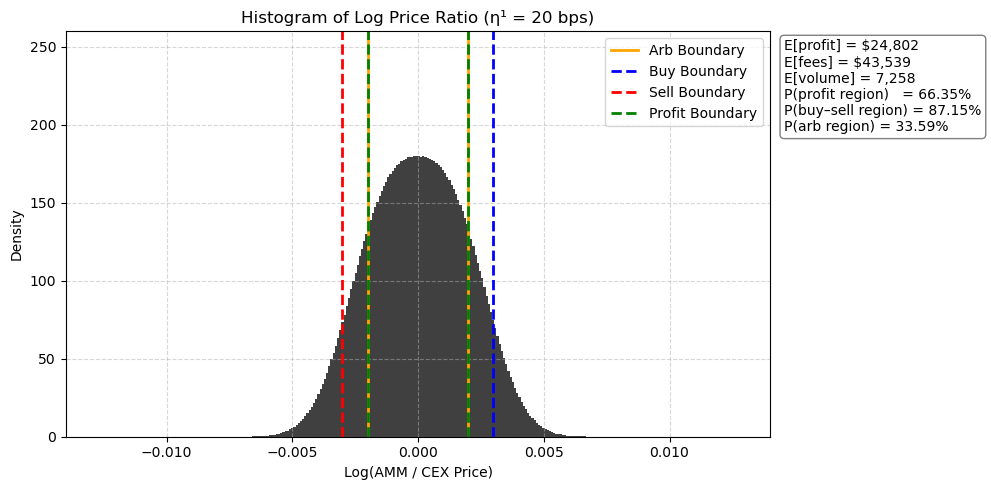

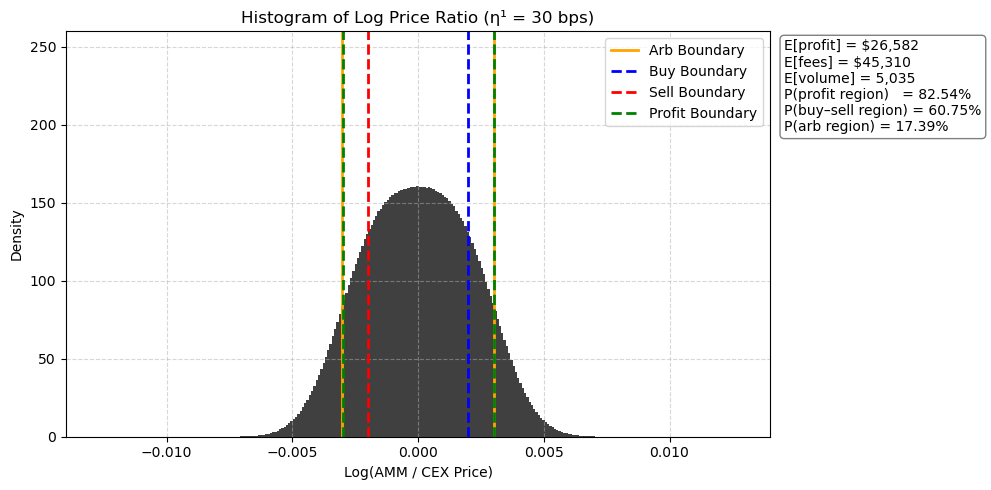

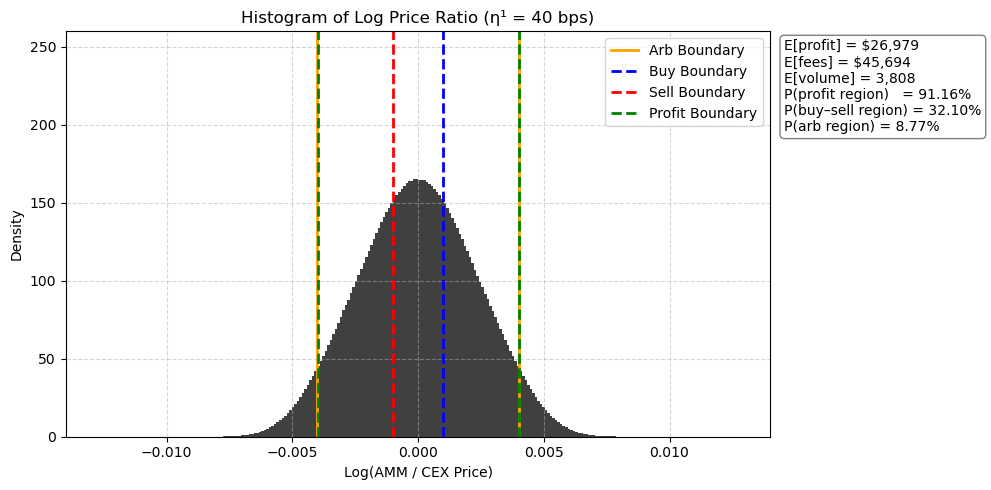

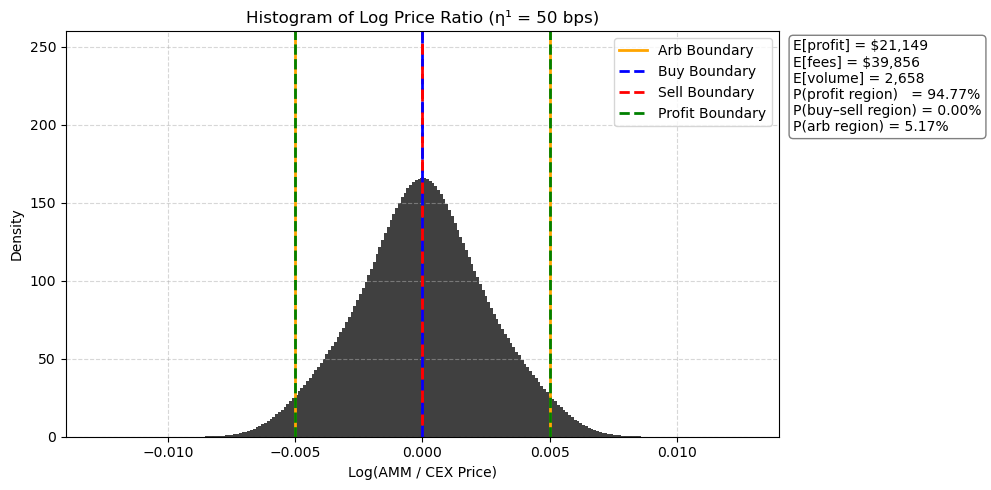

In [14]:
for eta1 in eta1_values:
    # flatten & log‐ratios
    log_ratios = np.log(results[eta1]['ratio'].flatten())

    # boundaries
    arb_lower         = np.log((1 - eta1) / (1 + etaA))
    arb_upper         = np.log((1 + etaA) / (1 - eta1))
    buy_bound         = np.log((1 + eta0) / (1 + eta1))
    sell_bound        = np.log((1 - eta0) / (1 - eta1))
    profit_buy_bound  = np.log(1 / (1 + eta1))
    profit_sell_bound = np.log(1 / (1 - eta1))
    
    # probability in profit region
    mask_profit = (log_ratios >= profit_buy_bound) & (log_ratios <= profit_sell_bound)
    prob_profit = mask_profit.mean()
    
    # probability in buy–sell region
    mask_buy_sell = (log_ratios <= buy_bound) & (log_ratios >= sell_bound)
    prob_buy_sell = mask_buy_sell.mean()

    mask_arb = (log_ratios>=arb_upper) | (log_ratios<=arb_lower)
    prob_arb = mask_arb.mean()

    pnl = results[eta1]['pnl_hedged'][-1]
    pnl_avg = pnl.mean()

    fees = results[eta1]['fee_revenue'][-1]
    fees_avg = fees.mean()

    vol = results[eta1]['AMM_vol'][-1]
    vol_avg = vol.mean()

    # plot
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_xlim(-0.014, 0.014)
    ax.set_ylim(0,260)
    ax.hist(log_ratios, bins=200, density=True, alpha=0.75, color='black')

    # vertical lines
    ax.axvline(arb_lower,        color='orange', linewidth=2, label='Arb Boundary')
    ax.axvline(arb_upper,        color='orange', linewidth=2)
    ax.axvline(buy_bound,        color='blue',   linestyle='--', linewidth=2, label='Buy Boundary')
    ax.axvline(sell_bound,       color='red',    linestyle='--', linewidth=2, label='Sell Boundary')
    ax.axvline(profit_buy_bound, color='green',  linestyle='--', linewidth=2, label='Profit Boundary')
    ax.axvline(profit_sell_bound,color='green',  linestyle='--', linewidth=2)

    # special alternating‐dash for η₁=0.005
    if eta1 == 0.005:
        ymin, ymax = ax.get_ylim()
        num_dashes = 35
        ys = np.linspace(ymin, ymax, num_dashes+1)
        segments = [[(sell_bound, ys[i]), (sell_bound, ys[i+1])]
                    for i in range(num_dashes)]
        colors = ['blue' if i % 2 == 0 else 'red'
                  for i in range(num_dashes)]
        lc = LineCollection(segments, colors=colors, linewidths=2)
        ax.add_collection(lc)

    # labels, grid
    ax.set_xlabel('Log(AMM / CEX Price)')
    ax.set_ylabel('Density')
    eta1_bps = int(eta1 * 1e4)
    ax.set_title(f'Histogram of Log Price Ratio (η¹ = {eta1_bps} bps)')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='best')

    # make room on right
    plt.subplots_adjust(right=0.75)

    # annotate probabilities
    textstr = (
        f"E[profit] = ${pnl_avg:,.0f}\n"
        f"E[fees] = ${fees_avg:,.0f}\n"
        f"E[volume] = {vol_avg:,.0f}\n"
        f"P(profit region)   = {prob_profit:5.2%}\n"
        f"P(buy–sell region) = {prob_buy_sell:5.2%}\n"
        f"P(arb region) = {prob_arb:5.2%}"
    )
    ax.text(1.02, 0.98, textstr,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray"))

    plt.tight_layout()
    plt.savefig(f'log_ratio_hist_eta1_{eta1:.3f}.pdf', bbox_inches='tight')
    plt.show()